In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-31 15:09:39.873104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


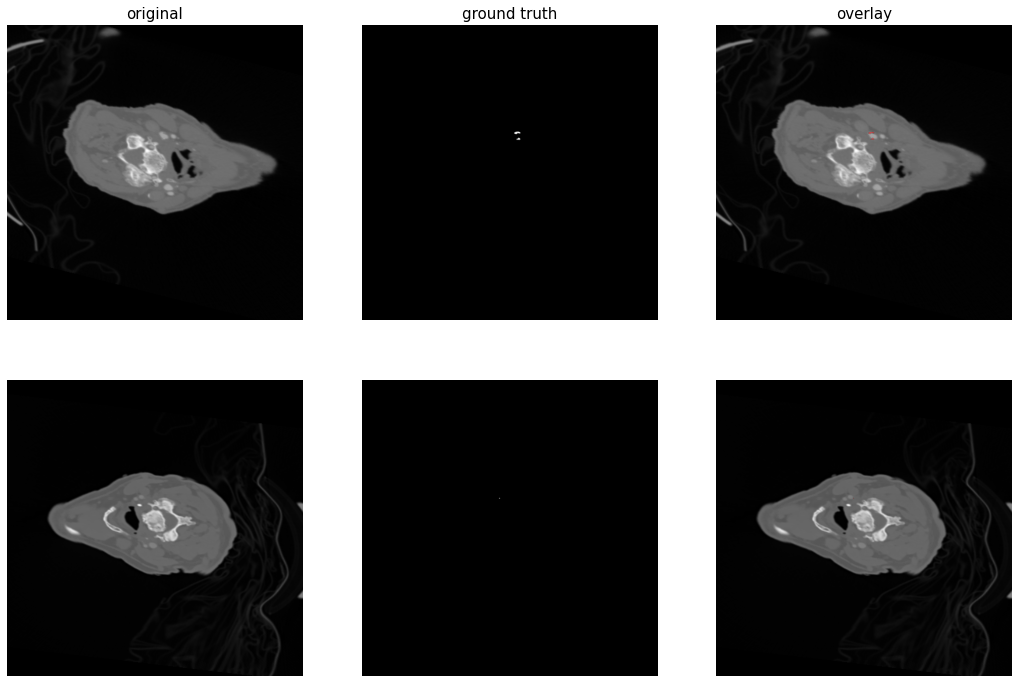

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-03-31 15:09:59.113840: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-31 15:09:59.227937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 15:09:59.230578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-31 15:09:59.230597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-31 15:09:59.278219: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(), # Adam(learning_rate=lr_schedule)
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(#X_train, 
                    #y_train, 
                    train_gen,
                    steps_per_epoch=100,
                    epochs=1000,
                    validation_data=(X_val, y_val)) # callbacks = [earlystopping]

2023-03-31 15:10:01.957621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-31 15:10:01.977171: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/1000


2023-03-31 15:10:03.210029: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-31 15:10:04.381002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-31 15:10:05.973209: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-31 15:10:05.973234: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-31 15:10:05.974398: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-31 15:10:06.039702: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-31 15:10:07.535541: I tensorflow/stream_exec

100/100 [==============================] - 35s 246ms/step - loss: 0.0434 - iou: 0.0020 - iou_thresholded: 0.0086 - val_loss: 0.0089 - val_iou: 4.8783e-04 - val_iou_thresholded: 3.2212e-04
Epoch 2/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0147 - iou: 0.0023 - iou_thresholded: 0.0072 - val_loss: 0.0053 - val_iou: 3.7595e-04 - val_iou_thresholded: 3.2212e-04
Epoch 3/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0064 - iou: 0.0028 - iou_thresholded: 0.0090 - val_loss: 0.0069 - val_iou: 6.1537e-04 - val_iou_thresholded: 3.2212e-04
Epoch 4/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0060 - iou: 0.0030 - iou_thresholded: 0.0105 - val_loss: 0.0068 - val_iou: 5.8316e-04 - val_iou_thresholded: 3.2212e-04
Epoch 5/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0065 - iou: 0.0024 - iou_thresholded: 0.0079 - val_loss: 0.0079 - val_iou: 0.0012 - val_iou_thresholded: 3.2212e-04
Epoch 6/1000

Epoch 43/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0027 - iou: 0.0416 - iou_thresholded: 0.0420 - val_loss: 0.0023 - val_iou: 0.0845 - val_iou_thresholded: 0.1602
Epoch 44/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0023 - iou: 0.0504 - iou_thresholded: 0.0573 - val_loss: 0.0021 - val_iou: 0.0634 - val_iou_thresholded: 0.0428
Epoch 45/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.0651 - iou_thresholded: 0.0799 - val_loss: 0.0021 - val_iou: 0.0914 - val_iou_thresholded: 0.1095
Epoch 46/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0024 - iou: 0.0431 - iou_thresholded: 0.0561 - val_loss: 0.0021 - val_iou: 0.0942 - val_iou_thresholded: 0.1149
Epoch 47/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0028 - iou: 0.0509 - iou_thresholded: 0.0646 - val_loss: 0.0021 - val_iou: 0.0756 - val_iou_thresholded: 0.0692
Epoch 48/1000
100/100 [=======

100/100 [==============================] - 11s 108ms/step - loss: 0.0021 - iou: 0.0970 - iou_thresholded: 0.1564 - val_loss: 0.0019 - val_iou: 0.1360 - val_iou_thresholded: 0.1994
Epoch 86/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0024 - iou: 0.0814 - iou_thresholded: 0.1283 - val_loss: 0.0020 - val_iou: 0.1090 - val_iou_thresholded: 0.2234
Epoch 87/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - iou: 0.0916 - iou_thresholded: 0.1566 - val_loss: 0.0019 - val_iou: 0.1244 - val_iou_thresholded: 0.2227
Epoch 88/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0021 - iou: 0.0895 - iou_thresholded: 0.1441 - val_loss: 0.0018 - val_iou: 0.1474 - val_iou_thresholded: 0.2291
Epoch 89/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0024 - iou: 0.0875 - iou_thresholded: 0.1541 - val_loss: 0.0020 - val_iou: 0.1360 - val_iou_thresholded: 0.2631
Epoch 90/1000
100/100 [=====================

100/100 [==============================] - 11s 112ms/step - loss: 0.0020 - iou: 0.1119 - iou_thresholded: 0.1900 - val_loss: 0.0018 - val_iou: 0.1462 - val_iou_thresholded: 0.2093
Epoch 128/1000
100/100 [==============================] - 12s 119ms/step - loss: 0.0028 - iou: 0.0892 - iou_thresholded: 0.1619 - val_loss: 0.0018 - val_iou: 0.1360 - val_iou_thresholded: 0.1806
Epoch 129/1000
100/100 [==============================] - 11s 115ms/step - loss: 0.0024 - iou: 0.1092 - iou_thresholded: 0.1969 - val_loss: 0.0017 - val_iou: 0.1463 - val_iou_thresholded: 0.2254
Epoch 130/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0029 - iou: 0.0829 - iou_thresholded: 0.1342 - val_loss: 0.0021 - val_iou: 0.1042 - val_iou_thresholded: 0.0932
Epoch 131/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - iou: 0.0806 - iou_thresholded: 0.1777 - val_loss: 0.0018 - val_iou: 0.1401 - val_iou_thresholded: 0.1871
Epoch 132/1000
100/100 [================

100/100 [==============================] - 11s 108ms/step - loss: 0.0020 - iou: 0.1215 - iou_thresholded: 0.1939 - val_loss: 0.0017 - val_iou: 0.1544 - val_iou_thresholded: 0.2757
Epoch 170/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0032 - iou: 0.0943 - iou_thresholded: 0.1673 - val_loss: 0.0019 - val_iou: 0.1441 - val_iou_thresholded: 0.2599
Epoch 171/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - iou: 0.1073 - iou_thresholded: 0.1610 - val_loss: 0.0018 - val_iou: 0.1522 - val_iou_thresholded: 0.2715
Epoch 172/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0021 - iou: 0.1045 - iou_thresholded: 0.1972 - val_loss: 0.0017 - val_iou: 0.1549 - val_iou_thresholded: 0.2516
Epoch 173/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0018 - iou: 0.1164 - iou_thresholded: 0.1985 - val_loss: 0.0017 - val_iou: 0.1546 - val_iou_thresholded: 0.1876
Epoch 174/1000
100/100 [================

100/100 [==============================] - 11s 108ms/step - loss: 0.0018 - iou: 0.1279 - iou_thresholded: 0.2011 - val_loss: 0.0017 - val_iou: 0.1823 - val_iou_thresholded: 0.3032
Epoch 212/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0026 - iou: 0.1295 - iou_thresholded: 0.2273 - val_loss: 0.0018 - val_iou: 0.1533 - val_iou_thresholded: 0.2737
Epoch 213/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0020 - iou: 0.1065 - iou_thresholded: 0.1642 - val_loss: 0.0017 - val_iou: 0.1556 - val_iou_thresholded: 0.2191
Epoch 214/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.1318 - iou_thresholded: 0.2411 - val_loss: 0.0017 - val_iou: 0.1743 - val_iou_thresholded: 0.2778
Epoch 215/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0018 - iou: 0.1061 - iou_thresholded: 0.1670 - val_loss: 0.0017 - val_iou: 0.1713 - val_iou_thresholded: 0.2332
Epoch 216/1000
100/100 [================

100/100 [==============================] - 11s 110ms/step - loss: 0.0018 - iou: 0.1264 - iou_thresholded: 0.2040 - val_loss: 0.0017 - val_iou: 0.1764 - val_iou_thresholded: 0.2274
Epoch 254/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.1360 - iou_thresholded: 0.2215 - val_loss: 0.0018 - val_iou: 0.1773 - val_iou_thresholded: 0.2980
Epoch 255/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.1154 - iou_thresholded: 0.1767 - val_loss: 0.0017 - val_iou: 0.1670 - val_iou_thresholded: 0.2660
Epoch 256/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0017 - iou: 0.1417 - iou_thresholded: 0.2331 - val_loss: 0.0016 - val_iou: 0.1734 - val_iou_thresholded: 0.2537
Epoch 257/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0020 - iou: 0.1117 - iou_thresholded: 0.1857 - val_loss: 0.0017 - val_iou: 0.1704 - val_iou_thresholded: 0.2880
Epoch 258/1000
100/100 [================

100/100 [==============================] - 11s 108ms/step - loss: 0.0019 - iou: 0.1320 - iou_thresholded: 0.2261 - val_loss: 0.0016 - val_iou: 0.1792 - val_iou_thresholded: 0.2233
Epoch 296/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0022 - iou: 0.1138 - iou_thresholded: 0.1963 - val_loss: 0.0016 - val_iou: 0.1850 - val_iou_thresholded: 0.2419
Epoch 297/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0021 - iou: 0.1260 - iou_thresholded: 0.2096 - val_loss: 0.0016 - val_iou: 0.1723 - val_iou_thresholded: 0.2321
Epoch 298/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0016 - iou: 0.1443 - iou_thresholded: 0.2242 - val_loss: 0.0016 - val_iou: 0.1958 - val_iou_thresholded: 0.2427
Epoch 299/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0018 - iou: 0.1374 - iou_thresholded: 0.2161 - val_loss: 0.0015 - val_iou: 0.2081 - val_iou_thresholded: 0.2766
Epoch 300/1000
100/100 [================

100/100 [==============================] - 11s 109ms/step - loss: 0.0020 - iou: 0.1331 - iou_thresholded: 0.2251 - val_loss: 0.0015 - val_iou: 0.1923 - val_iou_thresholded: 0.2532
Epoch 338/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0018 - iou: 0.1256 - iou_thresholded: 0.1897 - val_loss: 0.0019 - val_iou: 0.1453 - val_iou_thresholded: 0.2942
Epoch 339/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0019 - iou: 0.1473 - iou_thresholded: 0.2479 - val_loss: 0.0017 - val_iou: 0.1785 - val_iou_thresholded: 0.3090
Epoch 340/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0020 - iou: 0.1356 - iou_thresholded: 0.2277 - val_loss: 0.0015 - val_iou: 0.1920 - val_iou_thresholded: 0.2862
Epoch 341/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - iou: 0.1284 - iou_thresholded: 0.2201 - val_loss: 0.0015 - val_iou: 0.1727 - val_iou_thresholded: 0.2917
Epoch 342/1000
100/100 [================

100/100 [==============================] - 11s 110ms/step - loss: 0.0018 - iou: 0.1235 - iou_thresholded: 0.1926 - val_loss: 0.0012 - val_iou: 0.2036 - val_iou_thresholded: 0.3031
Epoch 380/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0016 - iou: 0.1717 - iou_thresholded: 0.2755 - val_loss: 0.0014 - val_iou: 0.1767 - val_iou_thresholded: 0.2983
Epoch 381/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.1182 - iou_thresholded: 0.1878 - val_loss: 0.0013 - val_iou: 0.1466 - val_iou_thresholded: 0.2464
Epoch 382/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0018 - iou: 0.1175 - iou_thresholded: 0.1935 - val_loss: 0.0012 - val_iou: 0.1783 - val_iou_thresholded: 0.2180
Epoch 383/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0019 - iou: 0.1460 - iou_thresholded: 0.2327 - val_loss: 0.0013 - val_iou: 0.1874 - val_iou_thresholded: 0.2003
Epoch 384/1000
100/100 [================

Epoch 421/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0015 - iou: 0.1243 - iou_thresholded: 0.1990 - val_loss: 0.0016 - val_iou: 0.1357 - val_iou_thresholded: 0.1845
Epoch 422/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0019 - iou: 0.1075 - iou_thresholded: 0.1713 - val_loss: 6.9715e-04 - val_iou: 0.2184 - val_iou_thresholded: 0.2767
Epoch 423/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0020 - iou: 0.1313 - iou_thresholded: 0.1949 - val_loss: 0.0012 - val_iou: 0.1458 - val_iou_thresholded: 0.2278
Epoch 424/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0012 - iou: 0.1174 - iou_thresholded: 0.1831 - val_loss: 7.4423e-04 - val_iou: 0.1485 - val_iou_thresholded: 0.1973
Epoch 425/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0015 - iou: 0.1274 - iou_thresholded: 0.2073 - val_loss: 0.0012 - val_iou: 0.1988 - val_iou_thresholded: 0.2620
Epoch 426/1000
10

100/100 [==============================] - 11s 109ms/step - loss: 0.0022 - iou: 0.0801 - iou_thresholded: 0.0912 - val_loss: 0.0016 - val_iou: 0.0909 - val_iou_thresholded: 0.0604
Epoch 463/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0018 - iou: 0.0927 - iou_thresholded: 0.1472 - val_loss: 6.7909e-04 - val_iou: 0.1507 - val_iou_thresholded: 0.1575
Epoch 464/1000
100/100 [==============================] - 11s 108ms/step - loss: -1.2774e-04 - iou: 0.1127 - iou_thresholded: 0.1652 - val_loss: 7.0110e-04 - val_iou: 0.1822 - val_iou_thresholded: 0.1912
Epoch 465/1000
100/100 [==============================] - 11s 108ms/step - loss: 9.1239e-04 - iou: 0.1270 - iou_thresholded: 0.1817 - val_loss: 5.3021e-04 - val_iou: 0.1095 - val_iou_thresholded: 0.1128
Epoch 466/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0021 - iou: 0.0762 - iou_thresholded: 0.1001 - val_loss: -3.1816e-04 - val_iou: 0.1398 - val_iou_thresholded: 0.2288
Epoch 467/1000

100/100 [==============================] - 11s 109ms/step - loss: 0.0031 - iou: 0.0563 - iou_thresholded: 0.0569 - val_loss: 0.0023 - val_iou: 0.0661 - val_iou_thresholded: 0.0092
Epoch 504/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0023 - iou: 0.0758 - iou_thresholded: 0.0954 - val_loss: 0.0010 - val_iou: 0.1057 - val_iou_thresholded: 0.1000
Epoch 505/1000
100/100 [==============================] - 11s 108ms/step - loss: 1.1857e-04 - iou: 0.0970 - iou_thresholded: 0.1330 - val_loss: -0.0047 - val_iou: 0.1218 - val_iou_thresholded: 0.1695
Epoch 506/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - iou: 0.0799 - iou_thresholded: 0.0987 - val_loss: -0.0046 - val_iou: 0.1602 - val_iou_thresholded: 0.1999
Epoch 507/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0028 - iou: 0.0681 - iou_thresholded: 0.0897 - val_loss: -0.0024 - val_iou: 0.1280 - val_iou_thresholded: 0.2002
Epoch 508/1000
100/100 [=========

Epoch 545/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0016 - iou: 0.0860 - iou_thresholded: 0.1245 - val_loss: -0.0013 - val_iou: 0.1589 - val_iou_thresholded: 0.1957
Epoch 546/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0037 - iou: 0.0858 - iou_thresholded: 0.1105 - val_loss: -5.3255e-04 - val_iou: 0.1396 - val_iou_thresholded: 0.1830
Epoch 547/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0013 - iou: 0.0884 - iou_thresholded: 0.1164 - val_loss: -0.0024 - val_iou: 0.1452 - val_iou_thresholded: 0.2426
Epoch 548/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0012 - iou: 0.0932 - iou_thresholded: 0.1322 - val_loss: -0.0014 - val_iou: 0.1304 - val_iou_thresholded: 0.1458
Epoch 549/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0026 - iou: 0.1069 - iou_thresholded: 0.1603 - val_loss: -4.0423e-05 - val_iou: 0.1425 - val_iou_thresholded: 0.2373
Epoch 550/10

100/100 [==============================] - 11s 110ms/step - loss: 0.0060 - iou: 0.0531 - iou_thresholded: 0.0592 - val_loss: 0.0012 - val_iou: 0.0807 - val_iou_thresholded: 0.0890
Epoch 587/1000
100/100 [==============================] - 12s 119ms/step - loss: 0.0033 - iou: 0.0777 - iou_thresholded: 0.1120 - val_loss: 0.0013 - val_iou: 0.0981 - val_iou_thresholded: 0.1024
Epoch 588/1000
100/100 [==============================] - 16s 157ms/step - loss: 0.0025 - iou: 0.0851 - iou_thresholded: 0.1359 - val_loss: 0.0011 - val_iou: 0.1185 - val_iou_thresholded: 0.1474
Epoch 589/1000
100/100 [==============================] - 15s 153ms/step - loss: 0.0028 - iou: 0.0901 - iou_thresholded: 0.1400 - val_loss: 0.0010 - val_iou: 0.1022 - val_iou_thresholded: 0.2121
Epoch 590/1000
100/100 [==============================] - 15s 154ms/step - loss: 0.0029 - iou: 0.0693 - iou_thresholded: 0.1033 - val_loss: 8.5171e-04 - val_iou: 0.1002 - val_iou_thresholded: 0.1706
Epoch 591/1000
100/100 [============

Epoch 628/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0024 - iou: 0.0671 - iou_thresholded: 0.0931 - val_loss: 0.0017 - val_iou: 0.0997 - val_iou_thresholded: 0.1299
Epoch 629/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0020 - iou: 0.0923 - iou_thresholded: 0.1457 - val_loss: -0.0031 - val_iou: 0.1225 - val_iou_thresholded: 0.1126
Epoch 630/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0025 - iou: 0.0618 - iou_thresholded: 0.0715 - val_loss: 0.0019 - val_iou: 0.1161 - val_iou_thresholded: 0.1394
Epoch 631/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0014 - iou: 0.0715 - iou_thresholded: 0.1129 - val_loss: 0.0021 - val_iou: 0.0766 - val_iou_thresholded: 0.0666
Epoch 632/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0026 - iou: 0.0681 - iou_thresholded: 0.0872 - val_loss: 0.0021 - val_iou: 0.0647 - val_iou_thresholded: 0.0361
Epoch 633/1000
100/100 [

Epoch 670/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0035 - iou: 0.0373 - iou_thresholded: 0.0226 - val_loss: 0.0023 - val_iou: 0.0493 - val_iou_thresholded: 0.0288
Epoch 671/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0026 - iou: 0.0543 - iou_thresholded: 0.0693 - val_loss: 0.0021 - val_iou: 0.0938 - val_iou_thresholded: 0.0765
Epoch 672/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - iou: 0.0675 - iou_thresholded: 0.0883 - val_loss: 0.0019 - val_iou: 0.1158 - val_iou_thresholded: 0.1574
Epoch 673/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0023 - iou: 0.0670 - iou_thresholded: 0.0984 - val_loss: 0.0020 - val_iou: 0.0745 - val_iou_thresholded: 0.0539
Epoch 674/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - iou: 0.0767 - iou_thresholded: 0.1316 - val_loss: 0.0019 - val_iou: 0.1212 - val_iou_thresholded: 0.1712
Epoch 675/1000
100/100 [=

Epoch 712/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - iou: 0.0881 - iou_thresholded: 0.1381 - val_loss: 0.0022 - val_iou: 0.1393 - val_iou_thresholded: 0.1537
Epoch 713/1000
100/100 [==============================] - 11s 111ms/step - loss: 0.0019 - iou: 0.0958 - iou_thresholded: 0.1587 - val_loss: 0.0018 - val_iou: 0.1534 - val_iou_thresholded: 0.2117
Epoch 714/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - iou: 0.0948 - iou_thresholded: 0.1521 - val_loss: 0.0019 - val_iou: 0.1279 - val_iou_thresholded: 0.2377
Epoch 715/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - iou: 0.1085 - iou_thresholded: 0.1875 - val_loss: 0.0018 - val_iou: 0.1387 - val_iou_thresholded: 0.1653
Epoch 716/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0025 - iou: 0.0810 - iou_thresholded: 0.1054 - val_loss: 0.0018 - val_iou: 0.1467 - val_iou_thresholded: 0.1923
Epoch 717/1000
100/100 [=

Epoch 754/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0023 - iou: 0.0784 - iou_thresholded: 0.1223 - val_loss: 0.0019 - val_iou: 0.1108 - val_iou_thresholded: 0.1897
Epoch 755/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.0859 - iou_thresholded: 0.1214 - val_loss: 0.0019 - val_iou: 0.1460 - val_iou_thresholded: 0.2487
Epoch 756/1000
100/100 [==============================] - 11s 111ms/step - loss: 0.0020 - iou: 0.0960 - iou_thresholded: 0.1490 - val_loss: 0.0019 - val_iou: 0.1339 - val_iou_thresholded: 0.1587
Epoch 757/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0024 - iou: 0.0900 - iou_thresholded: 0.1560 - val_loss: 0.0018 - val_iou: 0.1182 - val_iou_thresholded: 0.1616
Epoch 758/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0019 - iou: 0.1009 - iou_thresholded: 0.1768 - val_loss: 0.0018 - val_iou: 0.1558 - val_iou_thresholded: 0.2239
Epoch 759/1000
100/100 [=

Epoch 796/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0021 - iou: 0.0814 - iou_thresholded: 0.1295 - val_loss: -1.6361e-04 - val_iou: 0.1378 - val_iou_thresholded: 0.1803
Epoch 797/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0029 - iou: 0.0970 - iou_thresholded: 0.1748 - val_loss: 0.0013 - val_iou: 0.1431 - val_iou_thresholded: 0.2456
Epoch 798/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0014 - iou: 0.1021 - iou_thresholded: 0.1547 - val_loss: 0.0022 - val_iou: 0.0737 - val_iou_thresholded: 0.1070
Epoch 799/1000
100/100 [==============================] - 11s 112ms/step - loss: 0.0016 - iou: 0.0828 - iou_thresholded: 0.1200 - val_loss: 0.0015 - val_iou: 0.1333 - val_iou_thresholded: 0.1971
Epoch 800/1000
100/100 [==============================] - 16s 155ms/step - loss: 0.0026 - iou: 0.0845 - iou_thresholded: 0.1305 - val_loss: 0.0019 - val_iou: 0.1232 - val_iou_thresholded: 0.1839
Epoch 801/1000
100/1

Epoch 838/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0018 - iou: 0.1093 - iou_thresholded: 0.1921 - val_loss: -1.9504e-04 - val_iou: 0.1600 - val_iou_thresholded: 0.2120
Epoch 839/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0028 - iou: 0.0905 - iou_thresholded: 0.1715 - val_loss: 5.9212e-04 - val_iou: 0.1367 - val_iou_thresholded: 0.2172
Epoch 840/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.1037 - iou_thresholded: 0.1880 - val_loss: 0.0016 - val_iou: 0.1412 - val_iou_thresholded: 0.2130
Epoch 841/1000
100/100 [==============================] - 11s 110ms/step - loss: 0.0024 - iou: 0.1039 - iou_thresholded: 0.1608 - val_loss: 0.0011 - val_iou: 0.1208 - val_iou_thresholded: 0.1619
Epoch 842/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0021 - iou: 0.0999 - iou_thresholded: 0.1637 - val_loss: -0.0032 - val_iou: 0.1440 - val_iou_thresholded: 0.2083
Epoch 843/1000


Epoch 880/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0029 - iou: 0.0833 - iou_thresholded: 0.1375 - val_loss: 0.0019 - val_iou: 0.1310 - val_iou_thresholded: 0.1944
Epoch 881/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0020 - iou: 0.0908 - iou_thresholded: 0.1303 - val_loss: 0.0018 - val_iou: 0.1447 - val_iou_thresholded: 0.1803
Epoch 882/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.0966 - iou_thresholded: 0.1511 - val_loss: 0.0018 - val_iou: 0.1415 - val_iou_thresholded: 0.1884
Epoch 883/1000
100/100 [==============================] - 11s 109ms/step - loss: 0.0013 - iou: 0.1026 - iou_thresholded: 0.1862 - val_loss: 5.6433e-04 - val_iou: 0.1362 - val_iou_thresholded: 0.2224
Epoch 884/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0025 - iou: 0.0967 - iou_thresholded: 0.1560 - val_loss: -0.0024 - val_iou: 0.1263 - val_iou_thresholded: 0.1857
Epoch 885/1000
100/1

100/100 [==============================] - 11s 110ms/step - loss: -0.0119 - iou: 0.0846 - iou_thresholded: 0.1381 - val_loss: 0.0064 - val_iou: 0.1432 - val_iou_thresholded: 0.1611
Epoch 922/1000
100/100 [==============================] - 11s 108ms/step - loss: -0.0041 - iou: 0.0818 - iou_thresholded: 0.1264 - val_loss: -0.0286 - val_iou: 0.1315 - val_iou_thresholded: 0.1549
Epoch 923/1000
100/100 [==============================] - 11s 108ms/step - loss: -0.0019 - iou: 0.0787 - iou_thresholded: 0.1224 - val_loss: -0.0202 - val_iou: 0.1119 - val_iou_thresholded: 0.2087
Epoch 924/1000
100/100 [==============================] - 11s 109ms/step - loss: -0.0237 - iou: 0.1150 - iou_thresholded: 0.1901 - val_loss: 0.0277 - val_iou: 0.1819 - val_iou_thresholded: 0.2356
Epoch 925/1000
100/100 [==============================] - 11s 109ms/step - loss: -0.0230 - iou: 0.0861 - iou_thresholded: 0.1251 - val_loss: -0.0116 - val_iou: 0.1215 - val_iou_thresholded: 0.1650
Epoch 926/1000
100/100 [========

100/100 [==============================] - 11s 108ms/step - loss: 0.0024 - iou: 0.0687 - iou_thresholded: 0.1065 - val_loss: 0.0019 - val_iou: 0.0887 - val_iou_thresholded: 0.0919
Epoch 964/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0021 - iou: 0.1095 - iou_thresholded: 0.1724 - val_loss: 0.0018 - val_iou: 0.1323 - val_iou_thresholded: 0.2086
Epoch 965/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0022 - iou: 0.0883 - iou_thresholded: 0.1283 - val_loss: 0.0019 - val_iou: 0.1266 - val_iou_thresholded: 0.1280
Epoch 966/1000
100/100 [==============================] - 11s 111ms/step - loss: 0.0026 - iou: 0.0698 - iou_thresholded: 0.1097 - val_loss: 0.0019 - val_iou: 0.1282 - val_iou_thresholded: 0.1836
Epoch 967/1000
100/100 [==============================] - 11s 108ms/step - loss: 0.0023 - iou: 0.1024 - iou_thresholded: 0.1561 - val_loss: 0.0019 - val_iou: 0.1410 - val_iou_thresholded: 0.2344
Epoch 968/1000
100/100 [================

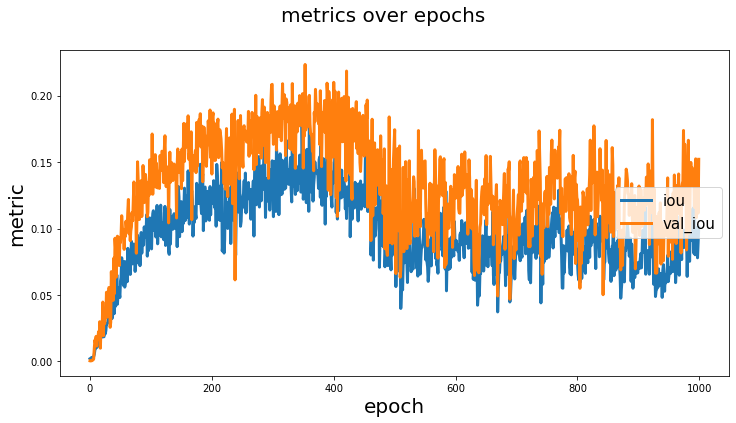

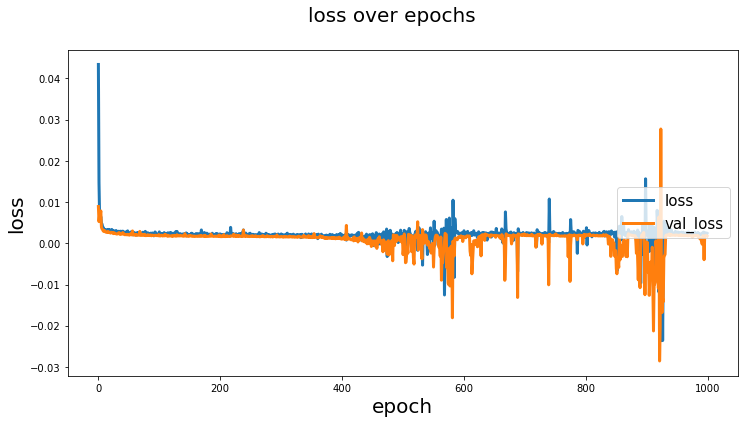

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

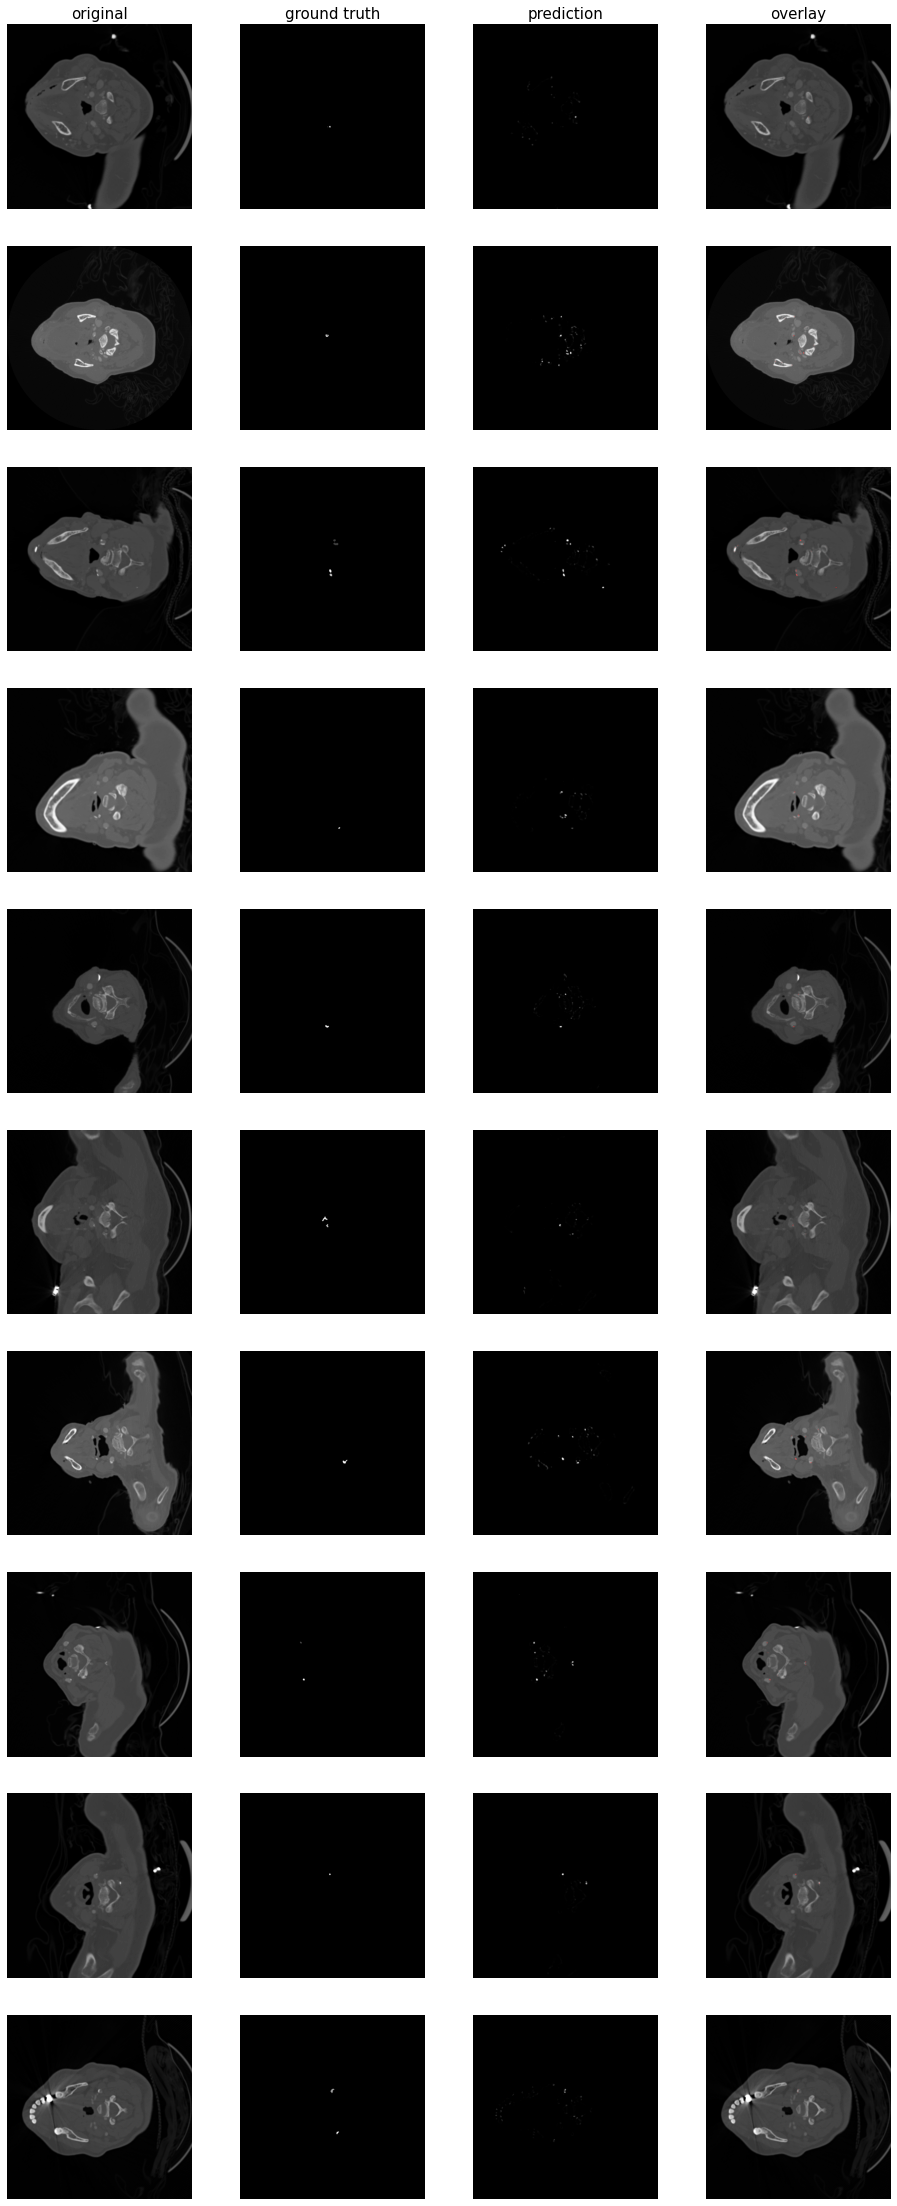

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 1s 199ms/step - loss: 0.0017 - iou: 0.1521 - iou_thresholded: 0.2020
